# Notebook used to estimate epidemic waves

In [20]:
import pandas as pd
from functools import reduce
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.stats import skewnorm
import json

In [21]:
df = pd.read_csv('data/waves/world_r_eff.csv',
        usecols=['country','date','R'],
        squeeze=True
        ).sort_index()
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

In [22]:
trend_length = 14
logic_func = lambda r: reduce(lambda x, y: x + 1 if y else 0, r)

In [23]:
df_total = pd.DataFrame(columns=['country',	'date',	'R', 'upward_slope_days', 'downward_slope_days' ])
for country in tqdm(df.country.unique()):
    df_country = df.loc[df['country'] == country]
    
    # counts number consecutive days with R>=1 for a give date
    ser = df.loc[df['country'] == country]['R'] > 1
    df_country['upward_slope_days'] = ser.expanding().apply(logic_func)

    # counts number consecutive days with R<1 for a give date
    ser = df_country['R'] < 1
    df_country['downward_slope_days'] = ser.expanding().apply(logic_func)

    #df_country = df_country[(df_country.upward_slope_days > 14) | (df_country.downward_slope_days > 14)]
    # append df to total_df
    df_total = pd.concat([df_total, df_country])
df_total = df_total[~df_total.country.isin(df_total[df_total.R < 0.10].country.unique())]
df_total = df_total[~df_total.country.isin(df_total[df_total.R > 3.06].country.unique())]
df_total = df_total[df_total.country != 'World']
df_total = df_total.reset_index().drop('index', axis=1)

100%|██████████| 182/182 [00:12<00:00, 14.24it/s]


In [24]:
ser = df_total['upward_slope_days'] >= 14
mask1 = df_total.index.isin(df_total['upward_slope_days'][ser & (ser != ser.shift(-1))].index)
ser = df_total['downward_slope_days'] >= 14
mask2 = df_total.index.isin(df_total['downward_slope_days'][ser & (ser != ser.shift(-1))].index)
df_wave = df_total[mask1 | mask2]

In [25]:
df_new = pd.DataFrame(columns=list(df_total.columns) + ['upward_period', 'downward_period'])
current_country = ""
slope_count = 1.0
mask = df_total['upward_slope_days'] >= 14
ix = df_total['upward_slope_days'][mask & (mask != mask.shift(-1))].index
for i in tqdm(ix):
    new_country = df_total.iloc[i].country
    if current_country != new_country:
        slope_count = 1.0
        current_country = new_country
    val = int(df_total.iloc[i]['upward_slope_days'])
    first_ix = i-val+1
    df_temp = df_total.iloc[first_ix:i+1]
    df_temp['upward_period'] = slope_count
    df_temp['downward_period'] = np.nan
    df_new = pd.concat([df_new, df_temp], ignore_index=True)
    slope_count += 1.0
mask = df_total['downward_slope_days'] >= 14
ix = df_total['downward_slope_days'][mask & (mask != mask.shift(-1))].index
for i in tqdm(ix):
    new_country = df_total.iloc[i].country
    if current_country != new_country:
        slope_count = 1.0
        current_country = new_country
    val = int(df_total.iloc[i]['downward_slope_days'])
    first_ix = i-val+1
    df_temp = df_total.iloc[first_ix:i+1]
    df_temp['upward_period'] = np.nan
    df_temp['downward_period'] = slope_count
    df_new = pd.concat([df_new, df_temp], ignore_index=True)
    slope_count += 1.0

countries = df_total.country.unique()
for c in tqdm(countries):
    df_total_country = df_total[df_total.country == c]
    df_new_country = df_new[df_new.country == c]
    neutral_dates = set(df_total_country.date) - set(df_new_country.date)
    mask1 = df_total.country == c
    mask2 = df_total.date.isin(neutral_dates)
    df_temp = df_total[mask1 & mask2]
    empty_series = np.empty(len(df_temp))
    empty_series[:] = np.nan
    df_temp['upward_period'] = empty_series
    df_temp['downward_period'] = empty_series
    dt = df_temp.date
    in_block = dt - dt.shift(1) == pd.Timedelta('1d')
    df_temp['neutral_period'] = np.zeros(len(df_temp))
    ix = in_block[~in_block].index
    for i in ix:
        df_temp.at[i, 'neutral_period'] = 1.0
    df_temp['neutral_period'] = np.cumsum(df_temp['neutral_period'])
    df_new = pd.concat([df_new, df_temp], ignore_index=True)
df_new = df_new.sort_values(by=['country', 'date']).reset_index().drop('index', axis=1)
mask1 = df_new.neutral_period > 0
mask2 = df_new.upward_period > 0
mask3 = df_new.downward_period > 0
is_neutral = pd.Series(mask1 & ~(mask2 | mask3))
func = lambda r: reduce(lambda x,y: x + 1 if y else 0, r)
tqdm.pandas()
df_new['neutral_slope_days'] = is_neutral.expanding().progress_apply(func)

100%|██████████| 153/153 [00:04<00:00, 37.07it/s]
57409it [05:06, 187.57it/s]


In [26]:
df_new = df_new[['country', 'date', 'R', 'upward_slope_days','upward_period','downward_slope_days','downward_period','neutral_slope_days','neutral_period']]
df_new.to_csv('data/waves/world_wave_data.csv', index=False)
df_full = df_new

In [57]:
# Drop entries where wavecount > 6
mask1 = df_full.upward_period < 7
mask2 = df_full.downward_period < 7
mask3 = df_full.neutral_period < 7
df_new = df_new[mask1 | mask2 | mask3]

In [58]:
ser = df_new['upward_slope_days'] >= 14
mask1 = df_new.index.isin(df_new['upward_slope_days'][ser & (ser != ser.shift(-1))].index)
ser = df_new['downward_slope_days'] >= 14
mask2 = df_new.index.isin(df_new['downward_slope_days'][ser & (ser != ser.shift(-1))].index)
ser = df_new['neutral_slope_days'] > 0
mask3 = df_new.index.isin(df_new['neutral_slope_days'][ser & (ser != ser.shift(-1))].index)
df_wave = df_new[mask1 | mask2 | mask3]

In [59]:
df_count = df_wave[['country','upward_period', 'downward_period', 'neutral_period']]
df_count['upward_period'] = df_count['upward_period'].apply(lambda x: True if x > 0 else False)
df_count['downward_period'] = df_count['downward_period'].apply(lambda x: True if x > 0 else False)
df_count['neutral_period'] = df_count['neutral_period'].apply(lambda x: True if x > 0 else False)
count_matrix = {
    "U": {
        "U": 0,
        "D": 0,
        "N": 0
    },
    "D": {
        "U": 0,
        "D": 0,
        "N": 0
    },
    "N":{
        "U": 0,
        "D": 0,
        "N": 0
    }
}
for c in tqdm(df_count.groupby('country')):
    df = c[1]
    previous = ""
    for i, row in enumerate(df.iterrows()):
        info = row[1]
        current = ""
        if info.upward_period:
            current = "U"
        elif info.downward_period:
            current = "D"
        elif info.neutral_period:
            current = "N"
        if previous and previous != current:
            count_matrix[previous][current] += 1
        previous = current

wave_transition_df = pd.DataFrame(count_matrix)
wave_transition_df = wave_transition_df/wave_transition_df.sum(axis=1).to_numpy().reshape(-1,1)

100%|██████████| 153/153 [00:00<00:00, 779.40it/s]


In [60]:
wave_transition_df.to_csv('data/waves/wave_transition.csv')

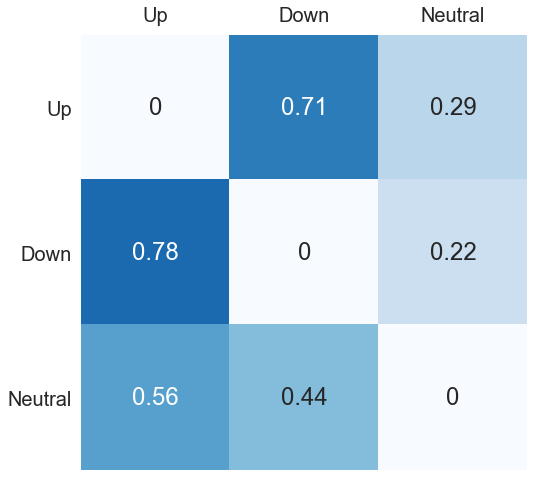

In [61]:
col_labels = ["Up", "Down", "Neutral"]
transition_matrix = wave_transition_df.values
sns.set(font_scale=2)
plt.figure(figsize=(8,8))
sns.heatmap(np.round(transition_matrix,2), vmin=0, vmax=1, annot=True, cmap="Blues", xticklabels=col_labels, yticklabels=col_labels, cbar=False)
plt.tick_params(axis='both', which='major', labelsize=20, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.yticks(rotation=0)
plt.savefig("plots/waves/transition_matrix.png",dpi=200)
plt.show()

In [62]:
df_up = df_wave[df_wave.upward_period > 0].drop(['downward_period', 'downward_slope_days', 'neutral_slope_days', 'neutral_period'], axis=1)
df_down = df_wave[df_wave.downward_period > 0].drop(['upward_period', 'upward_slope_days', 'neutral_slope_days', 'neutral_period'], axis=1)
df_neutral = df_wave[df_wave.neutral_period > 0].drop(['upward_period', 'upward_slope_days','downward_period', 'downward_slope_days'], axis=1)

In [63]:
up_R_params = df_new.groupby(['upward_period']).aggregate({"R": ["count", "mean", "min", "max", "skew", "std"]})
up_R_params.columns = up_R_params.columns.get_level_values(1)
up_R_params.index = up_R_params.index.astype(int)

down_R_params = df_new.groupby(['downward_period']).aggregate({"R": ["count", "mean", "min", "max", "skew", "std"]})
down_R_params.columns = down_R_params.columns.get_level_values(1)
down_R_params.index = down_R_params.index.astype(int)

neutral_R_params = df_new.groupby(['neutral_period']).aggregate({"R": ["count", "mean", "min", "max", "skew", "std"]})
neutral_R_params.columns = neutral_R_params.columns.get_level_values(1)
neutral_R_params.index = neutral_R_params.index.astype(int)

In [64]:
up_period_params = df_up.groupby(['upward_period']).aggregate({"upward_slope_days": ["count","mean","min", "max", "skew", "std"]})
up_period_params.columns = up_period_params.columns.get_level_values(1)
up_period_params.index = up_period_params.index.astype(int)

down_period_params = df_down.groupby(['downward_period']).aggregate({"downward_slope_days": ["count","mean","min", "max", "skew", "std"]})
down_period_params.columns = down_period_params.columns.get_level_values(1)
down_period_params.index = down_period_params.index.astype(int)

neutral_period_params = df_neutral.groupby(['neutral_period']).aggregate({"neutral_slope_days": ["count","mean","min", "max", "skew", "std"]})
neutral_period_params.columns = neutral_period_params.columns.get_level_values(1)
neutral_period_params.index = neutral_period_params.index.astype(int)

In [65]:
data = {}
R = {}
labels = ['U', 'D', 'N']
for i, df in enumerate([up_R_params, down_R_params, neutral_R_params]):
    R[labels[i]] = json.loads(df.to_json(orient='index'))
duration = {}
for i, df in enumerate([up_period_params, down_period_params, neutral_period_params]):
    duration[labels[i]] = json.loads(df.to_json(orient='index'))
data['R'] = R
data['duration'] = duration

In [66]:
with open('data/waves/wave_parameters.json', 'w') as file:
    json.dump(data, file, indent=4)

In [67]:
ser = df_new['upward_slope_days'] > 14
up = df_new['upward_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'upward_slope_days':'days'})
up['slope'] = pd.Series(['Upward' for _ in range(len(up))])

ser = df_new['downward_slope_days'] > 14
down = df_new['downward_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'downward_slope_days':'days'})
down['slope'] = pd.Series(['Downward' for _ in range(len(down))])

ser = df_new['neutral_slope_days'] > 0
neutral = df_new['neutral_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'neutral_slope_days':'days'})
neutral['slope'] = pd.Series(['Neutral' for _ in range(len(neutral))])

df_dist = pd.concat([up, down, neutral])

<Figure size 842.4x595.44 with 0 Axes>

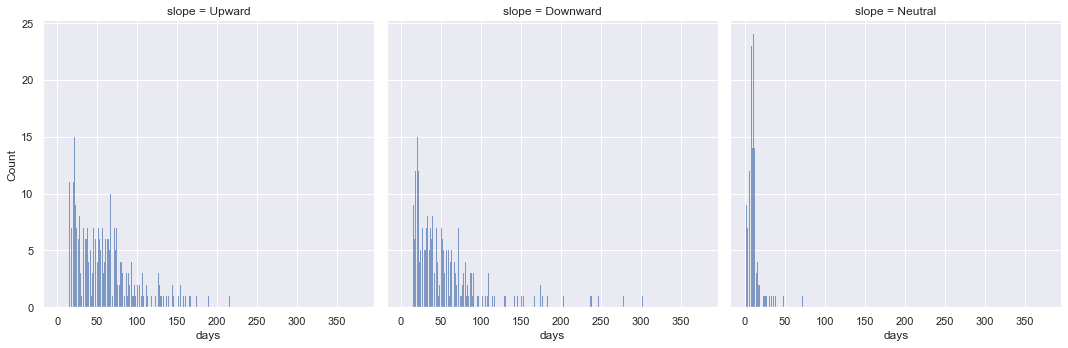

In [68]:
a4_dims = (11.7, 8.27)
plt.figure(figsize=a4_dims)
sns.displot(df_dist, x='days', col='slope', kind='hist', fill=True, height=5, aspect=1, bins=len(up))
plt.show()

<Figure size 842.4x595.44 with 0 Axes>

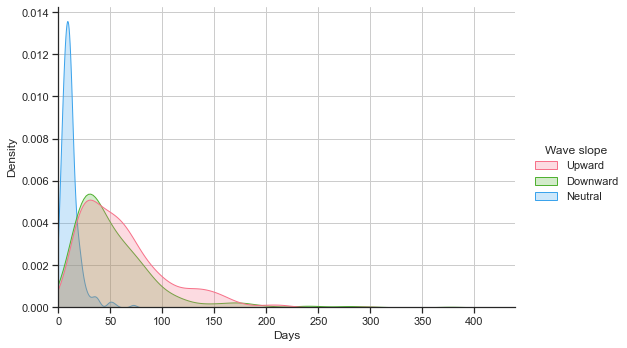

In [69]:
sns.set_style("ticks")
a4_dims = (11.7, 8.27)
plt.figure(figsize=a4_dims)
ax = sns.displot(df_dist, x='days', hue='slope', kind='kde', fill=True, aspect=1.5, palette="husl")
ax._legend.set_title("Wave slope")
ax.set(xlabel="Days")
plt.xlim(0)
plt.grid()
plt.savefig("plots/waves/wave_duration.png", dpi=200)
plt.show()

## Duration

In [45]:
df_new[df_new.upward_period > 0].groupby(['upward_period','upward_slope_days']).R.describe()

count      mean       std       min  \
upward_period upward_slope_days                                        
1.0           1.0                152.0  1.501164  0.541999  1.000027   
              2.0                152.0  1.517212  0.529772  1.005931   
              3.0                152.0  1.534238  0.518610  1.011044   
              4.0                152.0  1.548918  0.511952  1.017609   
              5.0                152.0  1.561300  0.503575  1.021679   
...                                ...       ...       ...       ...   
9.0           20.0                 1.0  1.092549       NaN  1.092549   
              21.0                 1.0  1.066175       NaN  1.066175   
              22.0                 1.0  1.058161       NaN  1.058161   
              23.0                 1.0  1.052225       NaN  1.052225   
              24.0                 1.0  1.045653       NaN  1.045653   

                                      25%       50%       75%       max  
upward_period upward_slope_days                                          
1.0           1.0                1.054044  1.296607  1.777474  2.989860  
              2.0                1.099898  1.288079  1.756184  2.984207  
              3.0                1.133715  1.345368  1.789351  2.981374  
              4.0                1.163363  1.338437  1.827211  3.054147  
              5.0                1.181629  1.351541  1.855916  3.020933  
...                                   ...       ...       ...       ...  
9.0           20.0               1.092549  1.092549  1.092549  1.092549  
              21.0               1.066175  1.066175  1.066175  1.066175  
              22.0               1.058161  1.058161  1.058161  1.058161  
              23.0               1.052225  1.052225  1.052225  1.052225  
              24.0               1.045653  1.045653  1.045653  1.045653  

[1209 rows x 8 columns]

<Figure size 432x288 with 0 Axes>

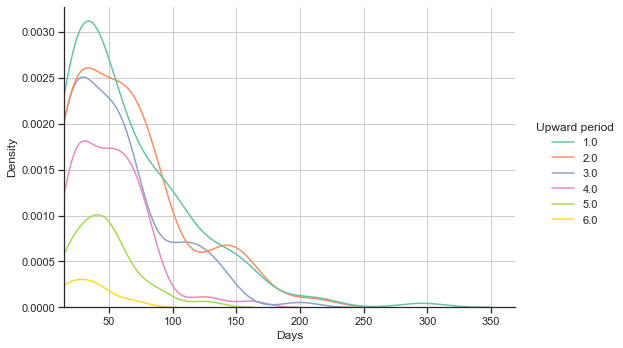

In [70]:
sns.set_style("ticks")
plt.figure()
ax = sns.displot(df_up, x='upward_slope_days', hue='upward_period', palette="Set2", kind='kde', aspect=1.5)
ax._legend.set_title("Upward period")
ax.set(xlabel="Days")
plt.xlim(15)
plt.grid()
plt.savefig("plots/waves/upward_period_duration.png", dpi=200)
plt.show()

<Figure size 432x288 with 0 Axes>

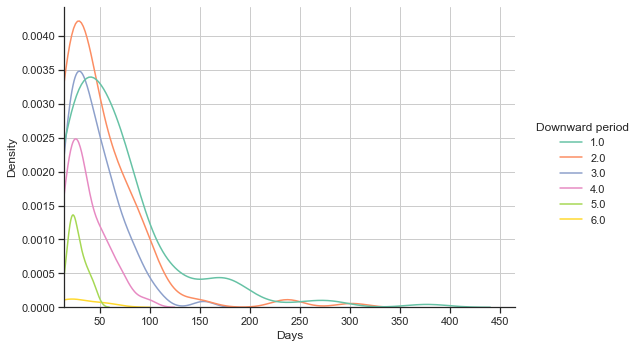

In [71]:
plt.figure()
ax = sns.displot(df_down, x='downward_slope_days', hue='downward_period', palette='Set2', kind='kde', aspect=1.5)
ax._legend.set_title("Downward period")
ax.set(xlabel="Days")
plt.xlim(15)
plt.grid()
plt.savefig("plots/waves/downward_period_duration.png", dpi=200)
plt.show()

<Figure size 432x288 with 0 Axes>

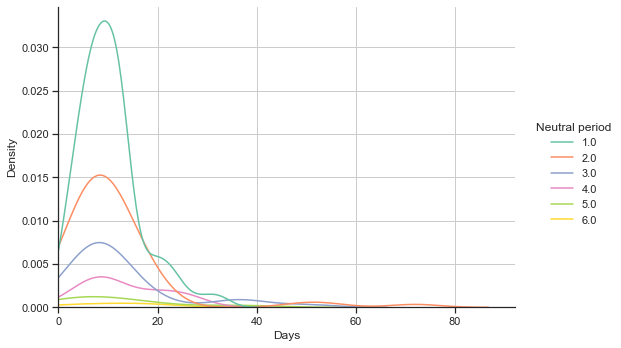

In [72]:
plt.figure()
ax = sns.displot(df_neutral, x='neutral_slope_days', hue='neutral_period', palette='Set2', kind='kde', aspect=1.5)
ax._legend.set_title("Neutral period")
ax.set(xlabel="Days")
plt.xlim(0)
plt.grid()
plt.savefig("plots/waves/neutral_period_duration.png", dpi=200)
plt.show()

## Reproduction number

<Figure size 432x288 with 0 Axes>

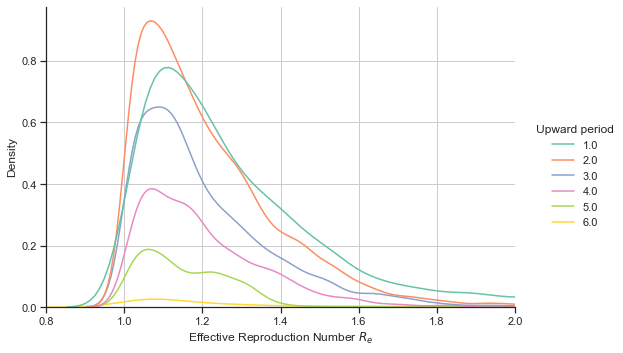

In [73]:
plt.figure()
ax = sns.displot(df_new[df_new.upward_period > 0], x='R', hue='upward_period', palette="Set2", kind='kde', aspect=1.5)
ax._legend.set_title("Upward period")
ax.set(xlabel=r"Effective Reproduction Number $R_e$")
plt.xlim([0.8,2])
plt.grid()
plt.savefig("plots/waves/upward_period_r.png", dpi=200)
plt.show()

<Figure size 432x288 with 0 Axes>

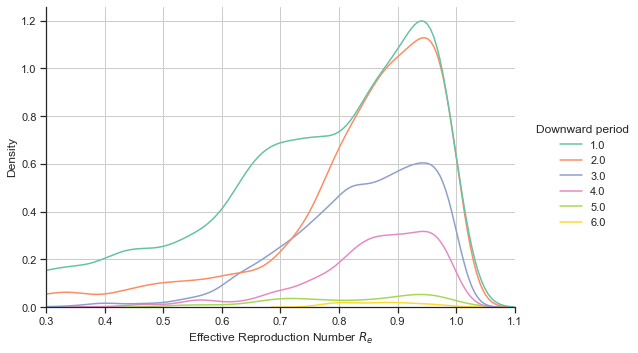

In [74]:
plt.figure()
ax = sns.displot(df_new[df_new.downward_period > 0], x='R', hue='downward_period', palette="Set2", kind='kde', aspect=1.5)
ax._legend.set_title("Downward period")
ax.set(xlabel=r"Effective Reproduction Number $R_e$")
plt.xlim([0.3,1.1])
plt.grid()
plt.savefig("plots/waves/downward_period_r.png", dpi=200)
plt.show()

<Figure size 432x288 with 0 Axes>

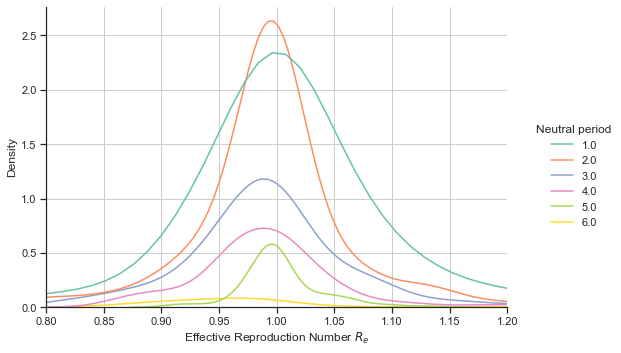

In [75]:
plt.figure()
ax = sns.displot(df_new[df_new.neutral_period > 0], x='R', hue='neutral_period', palette="Set2", kind='kde', aspect=1.5)
ax._legend.set_title("Neutral period")
ax.set(xlabel=r"Effective Reproduction Number $R_e$")
plt.xlim([0.8,1.2])
plt.grid()
plt.savefig("plots/waves/neutral_period_r.png", dpi=200)
plt.show()

In [181]:
from collections import Counter
horizon = 60
with open('data/wave_parameters.json') as file:
    data = json.load(file)
transition_mat = pd.read_csv('data/wave_transition.csv', index_col=0).T.to_dict()

R_timeline = np.ones(horizon)
current_state = 'U'
wave_state_history = []
i = 0
while True:
    wave_state_history.append(current_state)
    n_wave = Counter(wave_state_history)[current_state]
    params = data['duration'][current_state][str(n_wave)]
    duration = skewnorm.rvs(params['skew'], loc=params['mean'], scale=params['std']) // 7 # weeks
    duration = min(max(duration, params['min']), params['max'])
    try:
        for week in range(i, i+int(duration)):
            params = data['R'][current_state][str(n_wave)]
            R = skewnorm.rvs(params['skew'], loc=params['mean'], scale=params['std'])
            R = min(max(R, params['min']), params['max'])
            R_timeline[week] = R
        i += int(duration)
        current_state = np.random.choice(['U', 'D', 'N'], p=list(transition_mat[current_state].values()))
    except:
        print("Timeline generated")
        break

Timeline generated


In [182]:
R_timeline

array([1.33440274, 1.36756645, 1.74779405, 1.51510651, 1.62172957,
       1.45071861, 1.49264904, 1.75147403, 1.09494129, 1.37381101,
       1.75368548, 1.20607933, 1.35202001, 1.81538558, 0.72324589,
       0.88270577, 0.80772146, 0.87144487, 0.76114697, 0.99994245,
       0.88807637, 0.70704182, 0.74506922, 0.83099592, 0.81243606,
       0.87810966, 0.83304076, 0.95867095, 0.772728  , 0.71795108,
       0.82525095, 1.4378859 , 1.1864227 , 1.11911228, 1.23593298,
       1.42844254, 1.44957563, 1.31634731, 1.19200979, 1.50675525,
       1.37541896, 1.12325947, 1.20301093, 1.38618984, 1.44783476,
       0.85242048, 0.78008029, 0.77236377, 0.84192782, 0.78760238,
       0.83008474, 0.84141724, 0.96804177, 0.82521152, 0.85164753,
       0.86682312, 0.90110671, 0.91807967, 0.80354883, 0.81272603])

In [183]:
wave_state_history

['U', 'D', 'U', 'D']